# Train

In [17]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder, RegularIntervalDownsampler
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

# Settings

In [19]:
# PARAMETERS 

EXPERIMENT  = "test"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

# variables
dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc", "actevap"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "LSTMDataset" # "XBatchDataset"

# == MODEL  ========================================================================================

HIDDEN_SIZE = 12
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


# === SAMPLER/TRAINER ===================================================================================

# downsampling
DONWSAMPLING = True


SEED = 42
EPOCHS = 50
BATCH = 256

TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 360


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"



In [20]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# === READ TRAIN ===================================================================
Xd = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [22]:
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

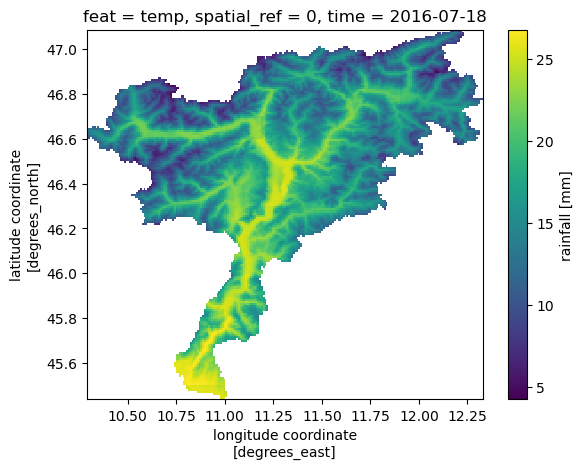

In [23]:
# viz input
Xd.unstack().isel(time=199).sel(feat="temp").plot()

In [24]:
if DONWSAMPLING:
   train_downsampler = RegularIntervalDownsampler(
        intervals=[4,4], origin=[0,0]
    )       
   test_downsampler = RegularIntervalDownsampler(
        intervals=[4,4], origin=[2,2]
    )
else:
    train_downsampler,test_downsampler = None,None

In [9]:
# === NORMALIZE ======================================================================

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xd.npy")
normalizer_static = Normalizer(method="standardize", type="space", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xs.npy")
normalizer_target = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_y.npy")


In [25]:
# === DATSET =======================================================================

train_dataset = get_dataset(DATASET)(
        Xd,
        Y,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = train_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)
test_dataset = get_dataset(DATASET)(
        Xd_test,
        Y_test,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = test_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)

[    0     1     2 ... 40137 40138 40139]
[    0     1     2 ... 40137 40138 40139]


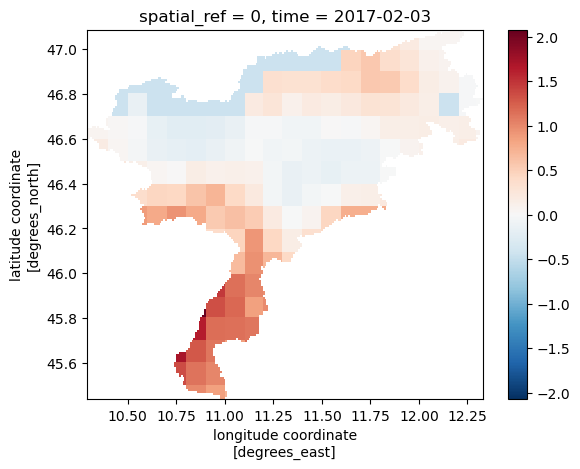

In [11]:
# viz torch datasets
from hython.utils import reshape_to_2Dspatial, to_xr
coords = read_from_zarr("https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/", group="xd").sel(time=train_temporal_range).coords
to_xr(reshape_to_2Dspatial(np.array(train_dataset.xd), *SHAPE, Xd.shape[1], Xd.shape[-1])[...,0], coords=coords).isel(time=399).plot()

In [26]:
# === SAMPLER ===================================================================


train_sampler_builder = SamplerBuilder(
    train_dataset,
    sampling="random", 
    processing="single-gpu")

test_sampler_builder = SamplerBuilder(
    test_dataset,
    sampling="sequential", 
    processing="single-gpu")


train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [27]:
# === DATA LOADER ================================================================

train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [28]:
# === MODEL ===================================================================

model = CuDNNLSTM(
                hidden_size=HIDDEN_SIZE, 
                dynamic_input_size=DYNAMIC_INPUT_SIZE,
                static_input_size=STATIC_INPUT_SIZE, 
                output_size=OUTPUT_SIZE
)

model.to(device)


CuDNNLSTM(
  (fc0): Linear(in_features=9, out_features=12, bias=True)
  (lstm): LSTM(12, 12, batch_first=True)
  (fc1): Linear(in_features=12, out_features=2, bias=True)
)

In [29]:
# === TRAIN ===================================================================
    
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

trainer = RNNTrainer(
    RNNTrainParams(
            experiment=EXPERIMENT,
            temporal_subsampling=TEMPORAL_SUBSAMPLING, 
            temporal_subset=TEMPORAL_SUBSET, 
            seq_length=SEQ_LENGTH, 
            target_names=target_names,
            metric_func=metric_fn,
            loss_func=loss_fn)
)

In [30]:
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    SURROGATE_MODEL_OUTPUT,
    device
)


  2%|█▉                                                                                               | 1/50 [00:02<02:25,  2.98s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.3632458746433258
val loss: 0.3059869706630707


  4%|███▉                                                                                             | 2/50 [00:05<02:23,  2.99s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.24644124507904053
val loss: 0.2516285181045532


  6%|█████▊                                                                                           | 3/50 [00:09<02:21,  3.01s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.22426818311214447
val loss: 0.23375917971134186


  8%|███████▊                                                                                         | 4/50 [00:12<02:19,  3.02s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.20825549960136414
val loss: 0.2238064706325531


 10%|█████████▋                                                                                       | 5/50 [00:15<02:15,  3.01s/it]

train loss: 0.2181258201599121
val loss: 0.22569775581359863


 12%|███████████▋                                                                                     | 6/50 [00:18<02:12,  3.02s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.19679422676563263
val loss: 0.19705142080783844


 14%|█████████████▌                                                                                   | 7/50 [00:21<02:09,  3.01s/it]

train loss: 0.19589725136756897
val loss: 0.204181507229805


 16%|███████████████▌                                                                                 | 8/50 [00:24<02:05,  3.00s/it]

train loss: 0.18624478578567505
val loss: 0.2178134024143219


 18%|█████████████████▍                                                                               | 9/50 [00:27<02:02,  2.99s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.17098425328731537
val loss: 0.19427382946014404


 20%|███████████████████▏                                                                            | 10/50 [00:30<01:59,  2.99s/it]

train loss: 0.1603894829750061
val loss: 0.19513677060604095


 22%|█████████████████████                                                                           | 11/50 [00:33<01:56,  3.00s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.16087789833545685
val loss: 0.18817050755023956


 24%|███████████████████████                                                                         | 12/50 [00:36<01:54,  3.01s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.15942880511283875
val loss: 0.17646415531635284


 26%|████████████████████████▉                                                                       | 13/50 [00:39<01:51,  3.02s/it]

train loss: 0.1447526067495346
val loss: 0.1773739606142044


 28%|██████████████████████████▉                                                                     | 14/50 [00:42<01:48,  3.01s/it]

train loss: 0.15221050381660461
val loss: 0.18674372136592865


 30%|████████████████████████████▊                                                                   | 15/50 [00:45<01:45,  3.01s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.1388523280620575
val loss: 0.17615589499473572


 32%|██████████████████████████████▋                                                                 | 16/50 [00:48<01:42,  3.03s/it]

train loss: 0.1441078931093216
val loss: 0.18416596949100494


 34%|████████████████████████████████▋                                                               | 17/50 [00:51<01:40,  3.05s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.14975838363170624
val loss: 0.1751277893781662


 36%|██████████████████████████████████▌                                                             | 18/50 [00:54<01:40,  3.13s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.14461730420589447
val loss: 0.17133910953998566


 38%|████████████████████████████████████▍                                                           | 19/50 [00:57<01:36,  3.12s/it]

train loss: 0.1343812197446823
val loss: 0.17752496898174286


 40%|██████████████████████████████████████▍                                                         | 20/50 [01:01<01:36,  3.23s/it]

train loss: 0.13817080855369568
val loss: 0.18116794526576996


 42%|████████████████████████████████████████▎                                                       | 21/50 [01:04<01:34,  3.26s/it]

train loss: 0.13677385449409485
val loss: 0.1897219568490982


 44%|██████████████████████████████████████████▏                                                     | 22/50 [01:07<01:31,  3.28s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.13833335041999817
val loss: 0.1683523952960968


 46%|████████████████████████████████████████████▏                                                   | 23/50 [01:10<01:27,  3.22s/it]

train loss: 0.1395961195230484
val loss: 0.18143188953399658


 48%|██████████████████████████████████████████████                                                  | 24/50 [01:14<01:22,  3.19s/it]

train loss: 0.13783250749111176
val loss: 0.17168891429901123


 50%|████████████████████████████████████████████████                                                | 25/50 [01:17<01:21,  3.27s/it]

train loss: 0.12942375242710114
val loss: 0.17468571662902832


 52%|█████████████████████████████████████████████████▉                                              | 26/50 [01:21<01:20,  3.35s/it]

train loss: 0.13321147859096527
val loss: 0.16866520047187805


 54%|███████████████████████████████████████████████████▊                                            | 27/50 [01:24<01:15,  3.29s/it]

train loss: 0.12950485944747925
val loss: 0.17907612025737762


 56%|█████████████████████████████████████████████████████▊                                          | 28/50 [01:27<01:11,  3.23s/it]

train loss: 0.1264587640762329
val loss: 0.18140879273414612


 58%|███████████████████████████████████████████████████████▋                                        | 29/50 [01:30<01:07,  3.19s/it]

train loss: 0.1269218474626541
val loss: 0.17645545303821564


 60%|█████████████████████████████████████████████████████████▌                                      | 30/50 [01:33<01:04,  3.21s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.12524214386940002
val loss: 0.15971434116363525


 62%|███████████████████████████████████████████████████████████▌                                    | 31/50 [01:36<01:00,  3.20s/it]

train loss: 0.13049861788749695
val loss: 0.17711080610752106


 64%|█████████████████████████████████████████████████████████████▍                                  | 32/50 [01:39<00:57,  3.18s/it]

train loss: 0.12350841611623764
val loss: 0.17235912382602692


 66%|███████████████████████████████████████████████████████████████▎                                | 33/50 [01:43<00:53,  3.16s/it]

train loss: 0.11619073152542114
val loss: 0.16785745322704315


 68%|█████████████████████████████████████████████████████████████████▎                              | 34/50 [01:46<00:50,  3.14s/it]

train loss: 0.12754283845424652
val loss: 0.1657751202583313


 70%|███████████████████████████████████████████████████████████████████▏                            | 35/50 [01:49<00:47,  3.15s/it]

train loss: 0.1199285164475441
val loss: 0.169541135430336


 72%|█████████████████████████████████████████████████████████████████████                           | 36/50 [01:52<00:43,  3.13s/it]

train loss: 0.1156969666481018
val loss: 0.1700151413679123


 74%|███████████████████████████████████████████████████████████████████████                         | 37/50 [01:55<00:40,  3.13s/it]

train loss: 0.12142537534236908
val loss: 0.16637535393238068


 76%|████████████████████████████████████████████████████████████████████████▉                       | 38/50 [01:58<00:37,  3.13s/it]

train loss: 0.11832895874977112
val loss: 0.1692473441362381


 78%|██████████████████████████████████████████████████████████████████████████▉                     | 39/50 [02:01<00:34,  3.13s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.12597870826721191
val loss: 0.1518356204032898


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 40/50 [02:04<00:31,  3.13s/it]

train loss: 0.1215507835149765
val loss: 0.1794131100177765


 82%|██████████████████████████████████████████████████████████████████████████████▋                 | 41/50 [02:08<00:28,  3.14s/it]

train loss: 0.12525971233844757
val loss: 0.1639026254415512


 84%|████████████████████████████████████████████████████████████████████████████████▋               | 42/50 [02:11<00:25,  3.17s/it]

train loss: 0.12255764752626419
val loss: 0.1706787645816803


 86%|██████████████████████████████████████████████████████████████████████████████████▌             | 43/50 [02:14<00:22,  3.22s/it]

train loss: 0.12145134061574936
val loss: 0.18145255744457245


 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 44/50 [02:17<00:19,  3.22s/it]

train loss: 0.12099209427833557
val loss: 0.17154453694820404


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 45/50 [02:21<00:16,  3.22s/it]

train loss: 0.12323091179132462
val loss: 0.16707061231136322


 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 46/50 [02:24<00:12,  3.20s/it]

train loss: 0.12394347041845322
val loss: 0.1745603084564209


 94%|██████████████████████████████████████████████████████████████████████████████████████████▏     | 47/50 [02:27<00:09,  3.20s/it]

train loss: 0.11531708389520645
val loss: 0.15521477162837982


 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 48/50 [02:30<00:06,  3.22s/it]

train loss: 0.12085925042629242
val loss: 0.1651037037372589


 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [02:33<00:03,  3.20s/it]

train loss: 0.11522740870714188
val loss: 0.15334469079971313


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:37<00:00,  3.14s/it]

train loss: 0.12057213485240936
val loss: 0.16328704357147217


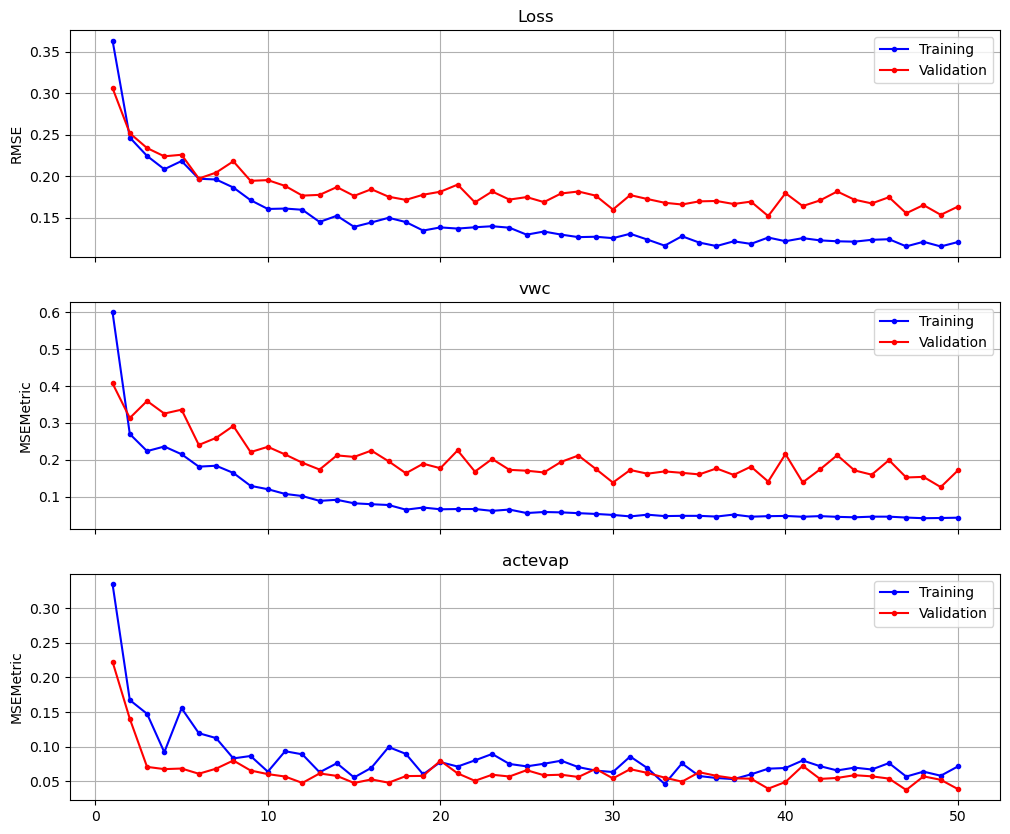

In [31]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))